# Data analysis + model selection

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style("darkgrid")
mpl.rcParams['figure.dpi'] = 150

# sklearn part
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [79]:
df = pd.read_csv("../data/churn.csv")

Three functions called at the beginning of analysis:

In [48]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [49]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Our goal will be to classify whether customer with given profile will leave the bank or not.
That means classification task.

In [51]:
# variable that we will try to predict
Y = df["churn"]

In [52]:
df.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

We can optimise the memory usage by appropriate column types changing.

In [80]:
df = (df
      .astype({"gender": "category", "country": "category", "products_number": "category",
               "credit_card": bool, "active_member": bool, "churn": "category"})
      .drop(["customer_id"], axis=1)
)
df

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,True,True,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,False,True,112542.58,0
2,502,France,Female,42,8,159660.80,3,True,False,113931.57,1
3,699,France,Female,39,1,0.00,2,False,False,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,True,True,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,True,False,96270.64,0
9996,516,France,Male,35,10,57369.61,1,True,True,101699.77,0
9997,709,France,Female,36,7,0.00,1,False,True,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,True,False,92888.52,1


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   credit_score      10000 non-null  int64   
 1   country           10000 non-null  category
 2   gender            10000 non-null  category
 3   age               10000 non-null  int64   
 4   tenure            10000 non-null  int64   
 5   balance           10000 non-null  float64 
 6   products_number   10000 non-null  category
 7   credit_card       10000 non-null  bool    
 8   active_member     10000 non-null  bool    
 9   estimated_salary  10000 non-null  float64 
 10  churn             10000 non-null  category
dtypes: bool(2), category(4), float64(2), int64(3)
memory usage: 449.9 KB


## EDA 

**Warning:** the explanatory data analysis presented below cannot be regarded as extensive. Much more deeper look into data is required.

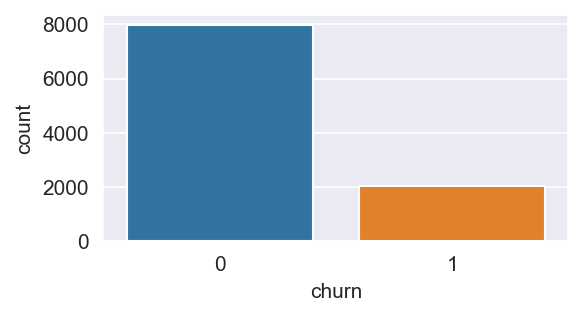

In [82]:
fig, ax = plt.subplots(figsize=(4, 2))
sns.countplot(data=df, x="churn")
plt.show()
# not balanced

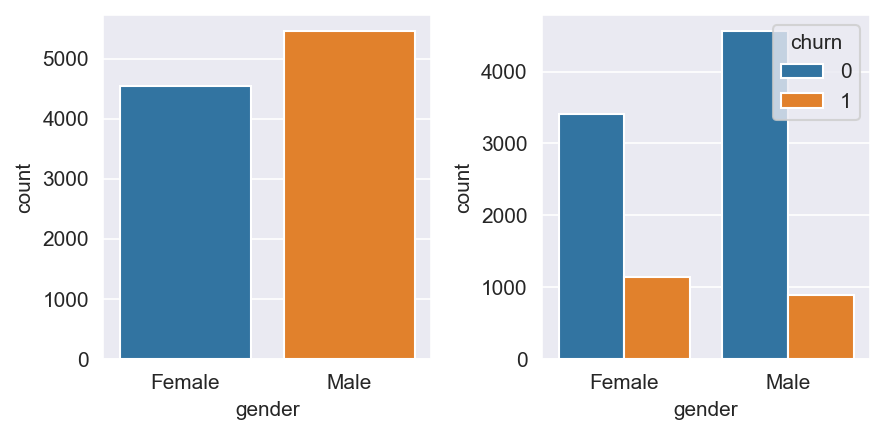

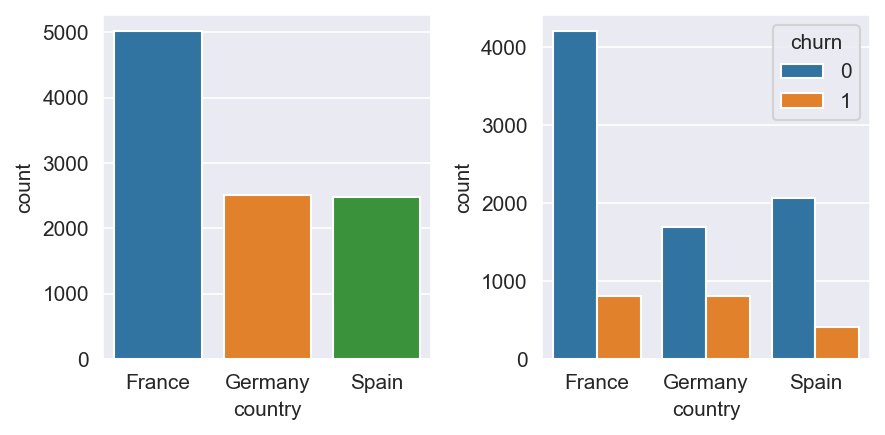

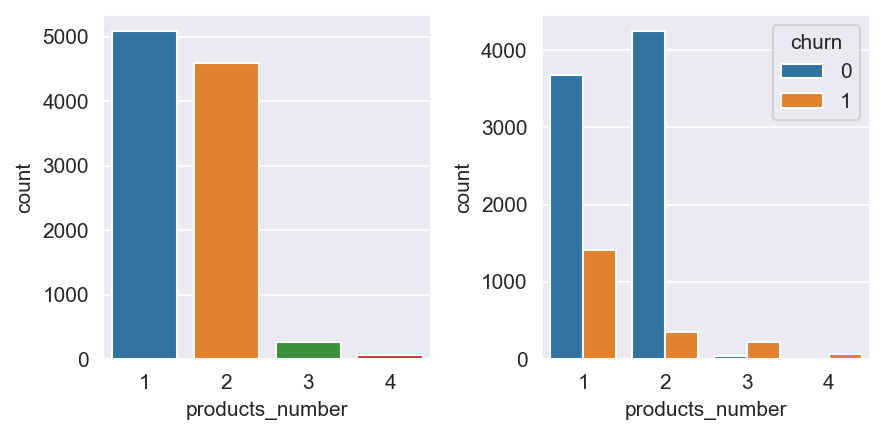

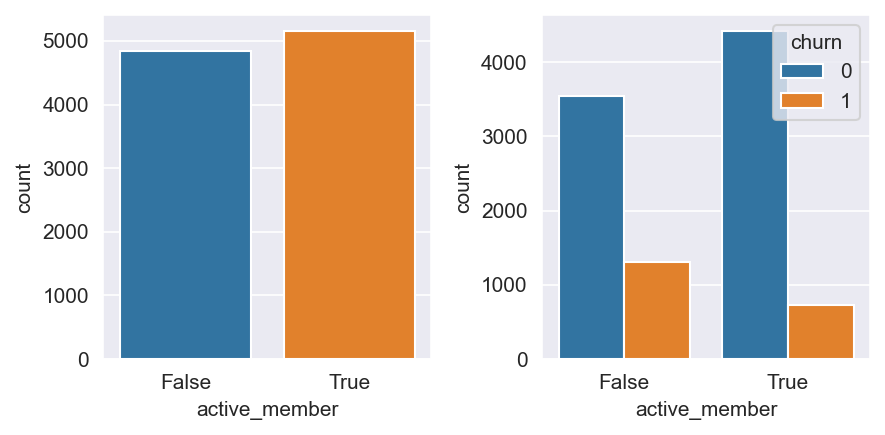

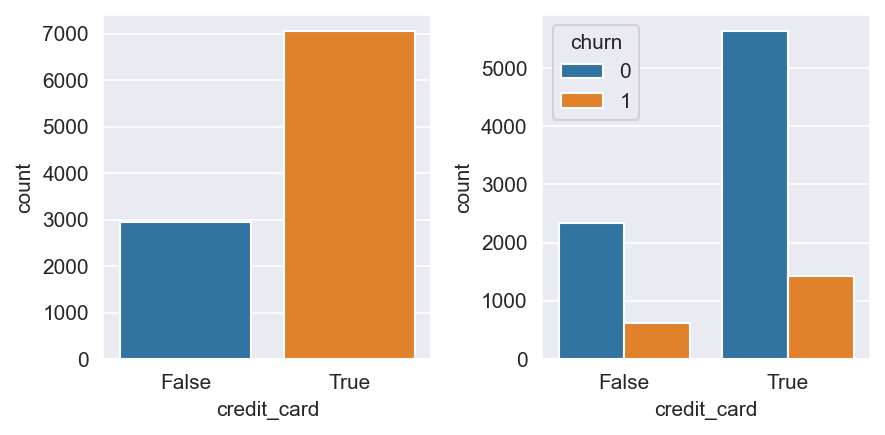

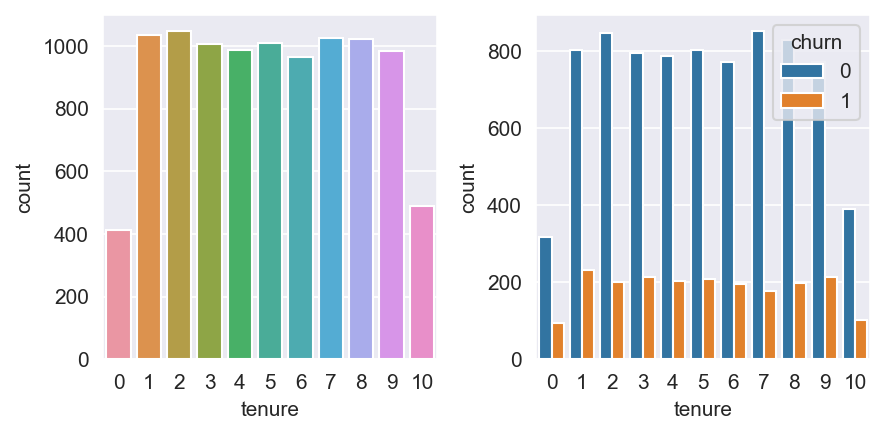

In [83]:
for column in ["gender", "country", "products_number", "active_member", "credit_card", "tenure"]:
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    sns.countplot(data=df, x=column, ax=ax[0])
    sns.countplot(data=df, x=column, hue="churn", ax=ax[1])
    plt.tight_layout()
    plt.show()

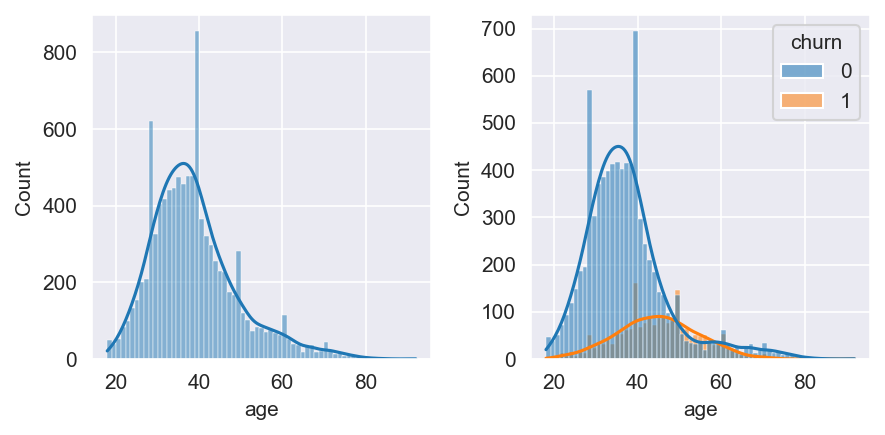

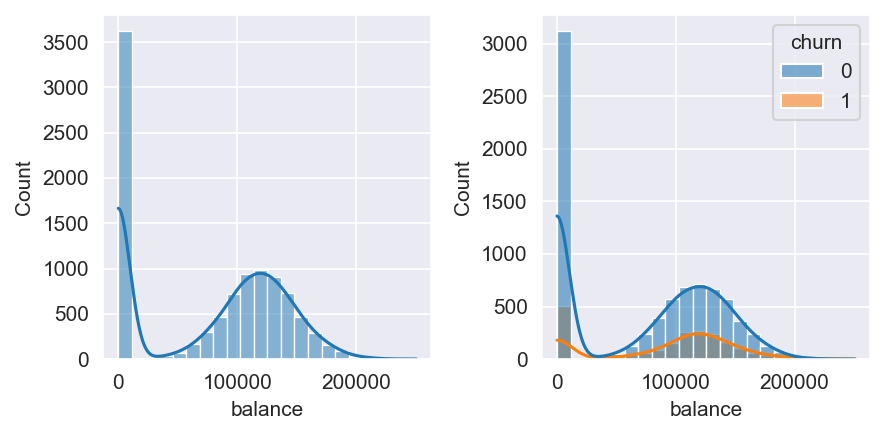

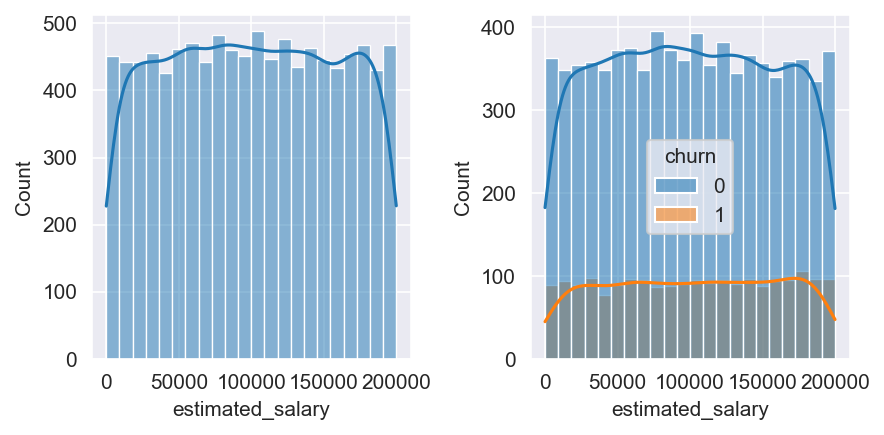

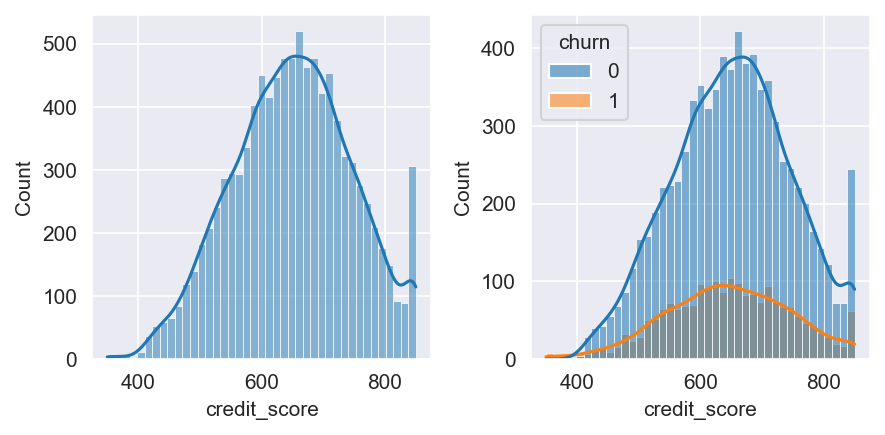

In [84]:
for column in ["age", "balance", "estimated_salary", "credit_score"]:
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    sns.histplot(data=df, x=column, kde=True, ax=ax[0])
    sns.histplot(data=df, x=column, hue="churn", kde=True, alpha=0.55, ax=ax[1])
    plt.tight_layout()
    plt.show()

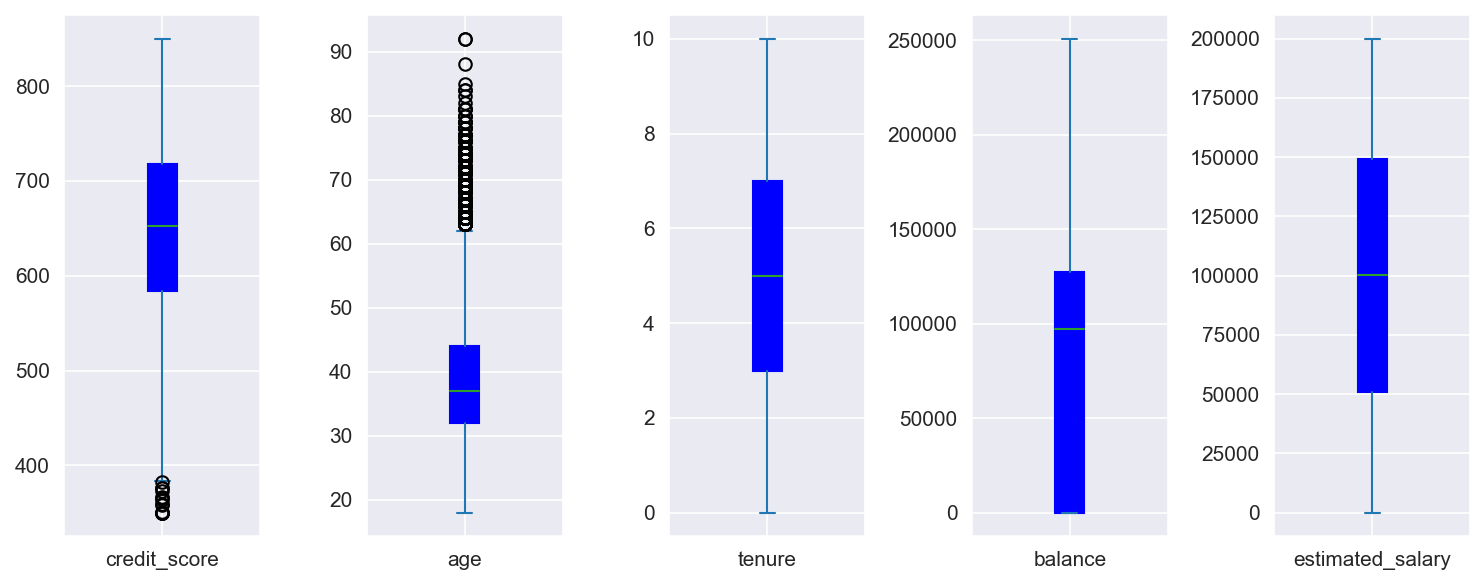

In [86]:
df.plot(kind='box', subplots=True, sharey=False, figsize=(10, 4), color=dict(boxes="Blue"), patch_artist=True)
plt.tight_layout()
plt.show()


<AxesSubplot:>

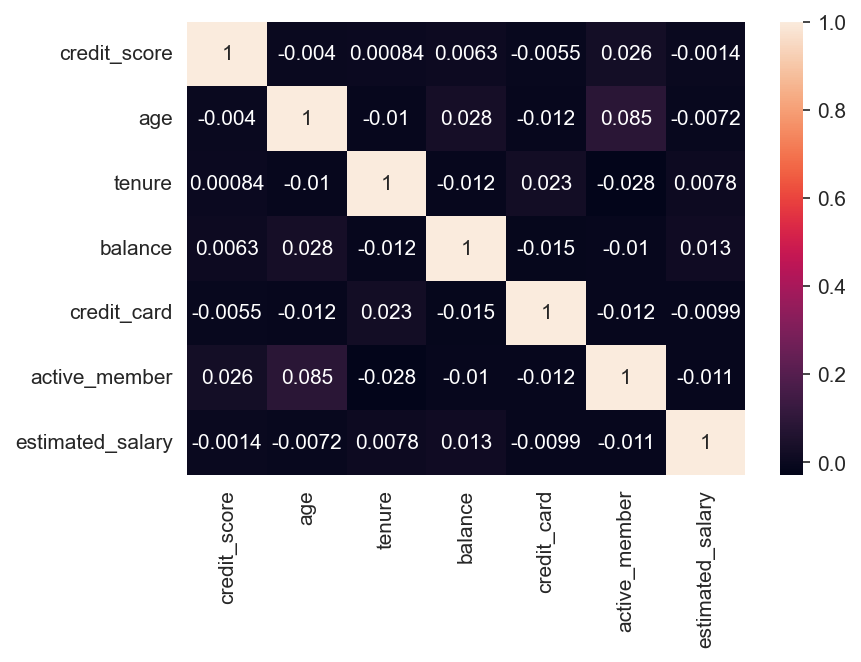

In [88]:
sns.heatmap(df.corr(), annot=True)

In [10]:
def quantile(p):
    def quantile_(x):
        return x.quantile(p)
    quantile_.__name__ = f'quantile({p})'
    return quantile_
    

(numerical.
 agg([np.mean, np.var, np.std, 'kurtosis', 'skew', quantile(0.25), quantile(0.5), quantile(0.75)]).
 T.
 assign(iqr=lambda df_:df_["quantile(0.75)"] - df_["quantile(0.25)"])
)

,mean,var,std,kurtosis,skew,quantile(0.25),quantile(0.5),quantile(0.75),iqr
credit_score,650.528800,9.341860e+03,96.653299,-0.425726,-0.071607,584.00,652.000,718.0000,134.0000
age,38.921800,1.099941e+02,10.487806,1.395347,1.011320,32.00,37.000,44.0000,12.0000
tenure,5.012800,8.364673e+00,2.892174,-1.165225,0.010991,3.00,5.000,7.0000,4.0000
balance,76485.889288,3.893436e+09,62397.405202,-1.489412,-0.141109,0.00,97198.540,127644.2400,127644.2400
products_number,1.530200,3.383218e-01,0.581654,0.582981,0.745568,1.00,1.000,2.0000,1.0000
estimated_salary,100090.239881,3.307457e+09,57510.492818,-1.181518,0.002085,51002.11,100193.915,149388.2475,98386.1375


## Machine learning part

In [150]:
df_ = df.drop("churn", axis=1)

In [151]:
numerical = list(filter(lambda x: df_[x].dtype in [np.int64, np.float64], df_.columns))

In [152]:
categorical = list(filter(lambda x: x not in numerical, df_.columns))

In [153]:
# column transformer
column_transformer = make_column_transformer(
    (StandardScaler(), numerical),
    (OneHotEncoder(drop="first"), categorical)
)


In [155]:
data = column_transformer.fit_transform(df_)

In [160]:
X_train, X_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.2, random_state=42)

In [157]:
clfs = [AdaBoostClassifier(), KNeighborsClassifier(), SVC(), GaussianProcessClassifier(),
        DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB()]

In [161]:
for clf in clfs:
    clf.fit(X_train, Y_train)
    print(clf.score(X_test, Y_test))

0.857
0.8365
0.8605
0.8545
0.787
0.8665
0.8235
